In [1]:
# code from https://www.tensorflow.org/lite/examples/on_device_training/overview#save_the_trained_weights

import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(device_lib.list_local_devices())
print("tensorflow version :", tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3188019383572106566
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10676994048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10380798116428036225
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:26:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
tensorflow version : 2.8.0


2022-07-09 14:35:30.073186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 14:35:30.435947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 10182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:26:00.0, compute capability: 8.6


---
TensorFlow Lite 모델에는 일반적으로 모델을 호출하여 추론을 실행할 수 있는 노출된 함수 메서드(또는 서명 ) 가 하나만 있습니다. 장치에서 모델을 훈련하고 사용하려면 모델에 대한 훈련, 추론, 저장 및 복원 기능을 포함하여 여러 개별 작업을 수행할 수 있어야 합니다. 먼저 TensorFlow 모델을 여러 기능을 갖도록 확장한 다음 모델을 TensorFlow Lite 모델 형식으로 변환할 때 이러한 기능을 서명으로 노출하여 이 기능을 활성화할 수 있습니다.   
   
아래 코드 예제는 TensorFlow 모델에 다음 함수를 추가하는 방법을 보여줍니다.   
   
* train함수는 훈련 데이터로 모델을 훈련시킵니다.
* infer함수는 추론을 호출합니다.
* save함수는 훈련 가능한 가중치를 파일 시스템에 저장합니다.
* restore함수는 파일 시스템에서 훈련 가능한 가중치를 로드합니다.

### Model

In [3]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

### Dataset

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

### Train

In [6]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/tmp/model.ckpt')

2022-07-09 14:35:33.198997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:26:00.0, compute capability: 8.6
2022-07-09 14:35:34.237097: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Finished 10 epochs
  loss: 0.428
Finished 20 epochs
  loss: 0.370
Finished 30 epochs
  loss: 0.336
Finished 40 epochs
  loss: 0.314
Finished 50 epochs
  loss: 0.297
Finished 60 epochs
  loss: 0.284
Finished 70 epochs
  loss: 0.275
Finished 80 epochs
  loss: 0.269
Finished 90 epochs
  loss: 0.266
Finished 100 epochs
  loss: 0.260


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/model.ckpt'>}

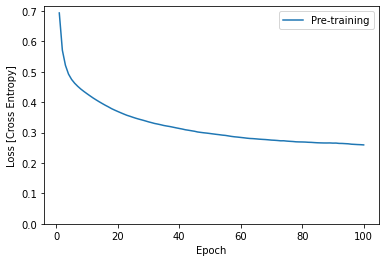

In [8]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

### Convert model to TensorFlow Lite format

In [9]:
SAVED_MODEL_DIR = "saved_models/edge_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

2022-07-09 14:36:46.112964: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/edge_model/assets


2022-07-09 14:36:46.600113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-09 14:36:46.600135: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-09 14:36:46.600727: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: saved_models/edge_model
2022-07-09 14:36:46.602589: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-09 14:36:46.602600: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: saved_models/edge_model
2022-07-09 14:36:46.606285: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-09 14:36:46.628336: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: saved_models/edge_model
2022-07-09 14:36:46.642305: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: succ

### Setup the TensorFlow Lite signatures

In [10]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

INFO: Created TensorFlow Lite delegate for select TF ops.
2022-07-09 14:37:14.402161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:26:00.0, compute capability: 8.6
INFO: TfLiteFlexDelegate delegate: 0 nodes delegated out of 17 nodes with 0 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Compare the output of the original model, and the converted lite model

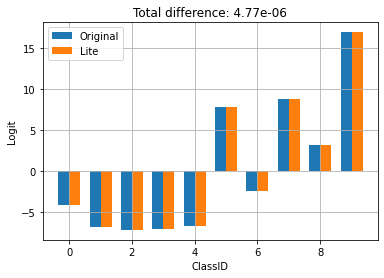

In [11]:
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

### Train on Edge

In [12]:
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 50
BATCH_SIZE = 100
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

: 

: 

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

### Save the trained weights

In [ ]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

### Restore the trained weights

In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)
another_interpreter.allocate_tensors()

infer = another_interpreter.get_signature_runner("infer")
restore = another_interpreter.get_signature_runner("restore")

logits_before = infer(x=train_images[:1])['logits'][0]

# Restore the trained weights from /tmp/model.ckpt
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

logits_after = infer(x=train_images[:1])['logits'][0]

compare_logits({'Before': logits_before, 'After': logits_after})

### Run Inference using trained weights

In [ ]:
infer = another_interpreter.get_signature_runner("infer")
result = infer(x=test_images)
predictions = np.argmax(result["output"], axis=1)

true_labels = np.argmax(test_labels, axis=1)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot(images, predictions, true_labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      color = 'b' if predictions[i] == true_labels[i] else 'r'
      plt.xlabel(class_names[predictions[i]], color=color)
  plt.show()

plot(test_images, predictions, true_labels)